<a href="https://colab.research.google.com/github/rviccinig/Forecasting_Cap_Rates_Time_Series/blob/main/LTSM__Good_Cap_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [276]:
#import Packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import itertools
import warnings
warnings.filterwarnings('ignore')

In [277]:
#Open Dataset
dataset=pd.read_csv("https://raw.githubusercontent.com/rviccinig/Forecasting_Cap_Rates_Time_Series/main/data_ready_2.csv", header=0)
# Drop all NA
dataset=dataset.dropna()
#Create Dates and Drop the Exisitn gDate
dates=pd.date_range(start='2003-09', periods=74, freq='Q')
dataset["date"]=dates
dataset.drop(['Date'], axis=1, inplace=True)
## Shifting the date to the first position, inserted in the first position
first_column = dataset.pop('date')  
dataset.insert(0, 'date', first_column)

LTSM MODEL - Prepare the Data

In [278]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [279]:
# convert series to supervised learning. this function basically takes the data, creates the lags for T and T-1
# Really nice function that creates lags
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [280]:
dataset.columns

Index(['date', 'Multifamily_Calgary_Downtown ',
       'Multifamily_Edmonton_Downtown ', 'Multifamily_Halifax_Downtown ',
       'Multifamily_Montreal_Downtown ', 'Multifamily_National_Downtown ',
       'Multifamily_Ottawa-Gatineau_Downtown ',
       'Multifamily_Toronto_Downtown ', 'Multifamily_Vancouver_Downtown ',
       'Multifamily_Montreal_Midtown', 'Multifamily_National_Overall',
       'Multifamily_Calgary_Suburban', 'Multifamily_Edmonton_Suburban',
       'Multifamily_Halifax_Suburban', 'Multifamily_Montreal_Suburban',
       'Multifamily_National_Suburban', 'Multifamily_Ottawa-Gatineau_Suburban',
       'Multifamily_Toronto_Suburban', 'Multifamily_Vancouver_Suburban', 'GOC',
       'Change_GOC'],
      dtype='object')

In [281]:
# Configuration File
relevant_variables=['date', 'Multifamily_Calgary_Downtown ','GOC']
dataset_2=dataset.filter(items=relevant_variables)

In [282]:
# Take only the values out of the Pandas Dataframe
values = dataset_2.values
# Make sure all your values are float
values[:,1:] = values[:,1:].astype('float32')
# normalize all features(Variables) to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values[:,1:])
#frame as supervised learning
#Reframed, what is doing is creating a pandas dataframe and creates lagged varibales , t-1
reframed = series_to_supervised(scaled, 2, 1)
reframed.drop(reframed.columns[[5]], axis=1, inplace=True)
reframed

,var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
2,1.000000,0.6,1.000000,0.6,1.000000
3,1.000000,0.6,1.000000,0.4,1.000000
4,1.000000,0.4,1.000000,0.6,0.857143
5,1.000000,0.6,0.857143,0.6,0.857143
6,0.857143,0.6,0.857143,0.6,0.857143
...,...,...,...,...,...
69,0.028571,0.0,0.057143,0.0,0.057143
70,0.057143,0.0,0.057143,0.0,0.057143
71,0.057143,0.0,0.057143,0.0,0.057143
72,0.057143,0.0,0.057143,0.0,0.057143


In [283]:
# Next step is to define and Fit the Model
# split into train and test sets, Before n_obs and After
values = reframed.values
n_obs = 50
train = values[:n_obs, :]
test = values[n_obs:, :]
# split into input and outputs, var(t) is my objective variable
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples(Observations), timesteps, features(Variables)]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(50, 1, 4) (50,) (22, 1, 4) (22,)


In [ ]:
# Now create the newral network
#Epochs = 50 , is the number of times I fit the data to the model
#50 in the LTSM function is the number of neurons

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


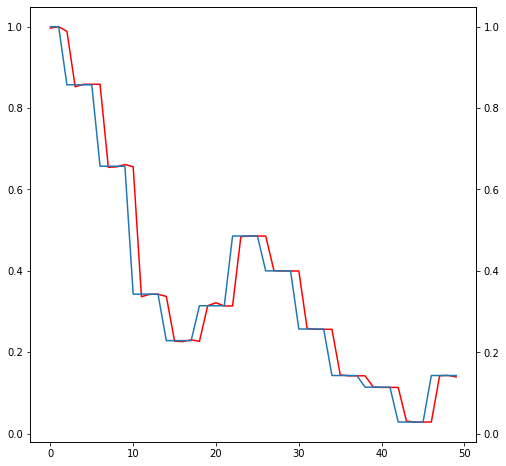

In [285]:
# Prediction
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

ax1.plot(list(range(50)), model.predict(train_X), color='red')
ax2.plot(list(range(50)), train_y)

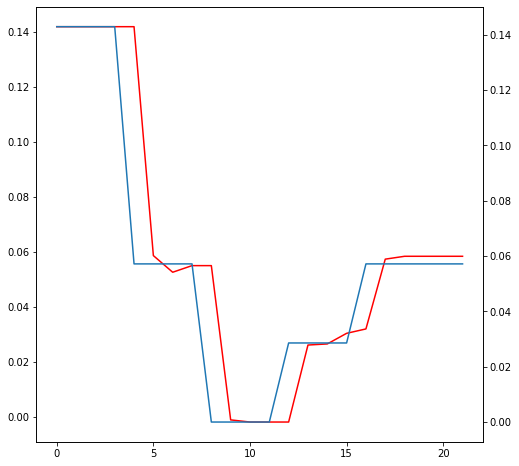

In [286]:
# Prediction
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

ax1.plot(list(range(22)), model.predict(test_X), color='red')
ax2.plot(list(range(22)), test_y)

In [291]:
predicted_values=model.predict(test_X)
predicitons_2=np.concatenate((predicted_values, predicted_values), axis=1)
predicitons_2
predicted_values = scaler.inverse_transform(predicitons_2)
clean_values_predicted=predicted_values[:, 0]
#scaler.inverse_transform(predicted_values)[:,1]

In [292]:
predicted_values=test_y.reshape(test_y.shape[0],1)
predicitons_2= np.concatenate((predicted_values, predicted_values), axis=1)
predicitons_2
predicted_values = scaler.inverse_transform(predicitons_2)
clean_values_real_values=predicted_values[:, 0]
#scaler.inverse_transform(predicted_values)[:,1]

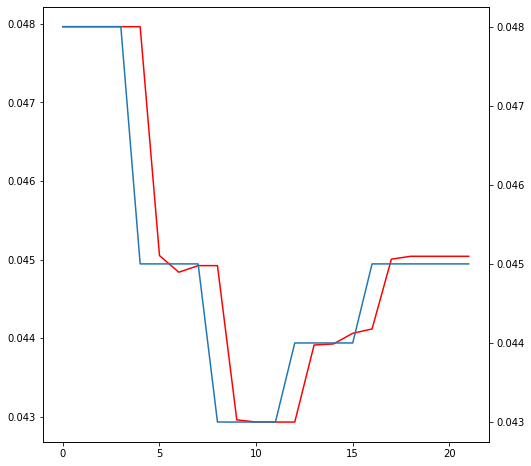

In [294]:
# Prediction
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

ax1.plot(list(range(clean_values_predicted.shape[0])),clean_values_predicted, color='red')
ax2.plot(list(range(clean_values_real_values.shape[0])),clean_values_real_values)

In [297]:
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50)                11000     
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________
None


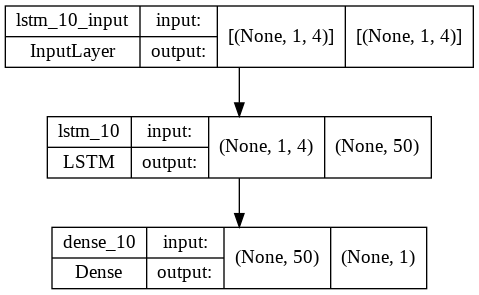

In [298]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [299]:
test_X[0]
#The order of the features are  var1(t-2)	var2(t-2)	var1(t-1)	var2(t-1)	where in this case var_1= cap rate and var_2=GOC 

array([[0.14285711, 0.19999999, 0.14285711, 0.19999999]])

In [305]:

# Transforming into a 3D array for test predictions, #The order of the features are  var1(t-2)	var2(t-2)	var1(t-1)	var2(t-1)	where in this case var_1= cap rate and var_2=GOC 
trying=test_X[0]
trying=trying.reshape(trying.shape[0], 1, trying.shape[1])
trying.shape

model.predict(trying)

array([[0.14181241]], dtype=float32)